<h1><center><strong><font color="chillipepper">Machine Translation</font></strong></center></h1>
<h3><center><font color="blue"><strong>Student Version</strong></font></center></h3>

------------------------

Google Colab Tips:
- CTRL + / => comment or uncomment current selection
- CTRL + ENTER -> run current cell
- SHIFT + ENTER -> run current cell and go to next one (or create a next empty one if none exists)
- ESCAPE -> when in a cell, goes to the outside of the cell, enabling ARROWS navigation
- ENTER -> when navigating between cells using ARROWS, press ENTER to start editing the cell
- don't forget you can fold and unfold sections (i.e. markdown sections)

In this lab you will have a glimspe of neural machine translation, in its simplest form. You will start from data representation to the creation of encoder and decoder models with a very different training loop.

# Outline

- Data Representation
  - Build a vocabulary
  - Add SOS and EOS
  - Create loaders
- Encoder Decoder
  - CUDA summary
  - Model definitions
  - Training loop
  - Evaluate function
  - Inference loop for validation
  - Training
  - Evaluation on test set
- On-demand Subjective evaluation
  - by random batch
  - by user input


This lab is inspired from the official PyTorch tutorial: https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html#the-seq2seq-model

However, it better corresponds to what you saw in the previous courses, and adapts it to make less convoluted.

Have fun!

# <font color="chillipepper">**Installations**</font>

In [ ]:
! pip install datasets transformers torchinfo sacrebleu

In [ ]:
import torch
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
from datasets import load_dataset
from tqdm import tqdm
import nltk
from gensim.models.phrases import Phrases, Phraser
from nltk.tokenize import TreebankWordTokenizer, TweetTokenizer
import pandas as pd
from termcolor import colored
from collections import Counter

from sacrebleu.metrics import BLEU

# <font color="chillipepper">**Data Representation**</font>



We will use a corpus made of English-French translation pairs. This dataset comes from Tatoeba, https://tatoeba.org/fr/. You can find more datasets from this wbsite here: https://tatoeba.org/fr/downloads.

We will only consider English-French pairs, but you are free to try other pairs if you wish to do so.

Keep in mind this corpus is not the best one to train a good model, but machine translation model can be really long to train. Hence we chose this one to obtain quick, alas not good, results. You are free to try other datasets afterwards.

**Disclaimer:** The model should be trained for at least ~40 minutes to obtain somewhat "correct" results. Ideally, the model should be trained on the whole trainset, with multiple epochs. But we will NOT do this. You will see later on that with the `limit` option, we can easily select the subset size for training. 

In [ ]:
! wget https://gitlab.com/gguibon/ensae-ml4nlp-storage/-/raw/master/eng-fra.zip
! unzip eng-fra.zip

In [ ]:
from datasets import load_dataset
enfr = load_dataset('json', data_files='eng-fra.json')

Using custom data configuration default-d882eb85dc9244ec
Reusing dataset json (/root/.cache/huggingface/datasets/json/default-d882eb85dc9244ec/0.0.0/ac0ca5f5289a6cf108e706efcf040422dbbfa8e658dee6a819f20d76bb84d26b)


  0%|          | 0/1 [00:00<?, ?it/s]

Our dataset only has a "train" set

In [ ]:
enfr

In [ ]:
# the number of telements in the train set
len(enfr['train'])

In [ ]:
UNK_IDX, PAD_IDX, SOS_IDX, EOS_IDX = 0, 1, 2, 3
special_symbols = ['<unk>', '<pad>', '<sos>', '<eos>']

Let's try a simple tokenization on one element of the corpus

In [ ]:
tok = TweetTokenizer()
entry = enfr['train'][2]['translation']
tokens = tok.tokenize(entry['fr'].lower().strip())
print(tokens)

## <font color="chillipepper">Build a Vocabulary from Scratch</font>

#### 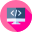 ☑️ **TODO: Count the vocab for both languages**



**Create your own vocab manually**, a dictionary `VOC` with multiple keys.
For each language `'en', 'fr'`:
- `counts`is the number of occurrence per token
- `stoi` is the String To Index mapping
- `itos` is the Index to String mapping
- `nbwords`is the global number of words




In [ ]:
# stoi string to index
# itos index to string

VOC = {'en': {'stoi': {}, 'counts': {}, 'nbwords': 0}, 'fr': {'stoi': {}, 'counts': {}, 'nbwords': 0}}
LANGS = ['fr', 'en']

def parse_entry(entry):
  # CODE ME!!

# now we add the special symbols
for lang in LANGS:
  for t in special_symbols: 
    VOC[lang]['stoi'][t] = VOC[lang]['nbwords']
    VOC[lang]['counts'][t] = 1
    VOC[lang]['nbwords'] += 1

In [ ]:
for entry in tqdm(enfr['train']): 
  parse_entry(entry)

# to compute the itos, we can just reverse the stoi
for lang in LANGS:
  VOC[lang]['itos'] = { v:k for k,v in VOC[lang]['stoi'].items()}

In [ ]:
print(VOC['fr']['itos'][1])

In [ ]:
print('fr', VOC['fr']['nbwords'], 'en', VOC['en']['nbwords'])

## <font color="chillipepper">Add SOS and EOS special indices and Tokenize</font>



#### 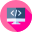☑️ **TODO: add SOS and EOS**

Add End of Sentence (EOS, `EOS_IDX`) and Start of Sentence (SOS, `SOS_IDX`) indices in the end and beginning of a list of tokens. 

This means, for each `LANGS`, you will have to:
1. tokenize the sentence
2. transform the tokens to their corresponding indice
3. surround the tokens with the SOS and EOS indices

In [ ]:
print(VOC['fr']['stoi']['va'])

In [ ]:
enfr['train'][0]

In [ ]:
def prepa(entry):
  res = {l:None for l in LANGS }
  for lang in LANGS:
    tokens_entries =  [ [SOS_IDX] + [ VOC[lang]['stoi'][t] for t in tok.tokenize(e[lang].lower().strip()) ] + [EOS_IDX] for e in entry['translation'] ] 
    res[lang] = tokens_entries
  return res
enfr['train'] = enfr['train'].map(lambda e: prepa(e), batched=True)

In [ ]:
## the following line would take the max len from the data (~60)
# maxlen = max([max([ len(e) for e in enfr['train']['en'] ]), max([ len(e) for e in enfr['train']['fr'] ]) ] )
## we will limit the maxlen to 10, in order to ease the computational process
maxlen = 10

## <font color="chillipepper">Split into train, val, test</font>

Now let's split the dataset into train, val and test splits.

In [ ]:
from sklearn.model_selection import train_test_split
# we retrieve a list of indices (required for the .select() method of the hugging face dataset object - which is not a dictionary -)
indices = [i for i in range(len(enfr['train']))]
# use scikit learn to split the indices into subsets: ~67% train, ~16 % val, ~16% test
train_indices, other_indices, _, _ = train_test_split(indices, indices, test_size=0.33, random_state=42)
val_indices, test_indices, _, _ = train_test_split(other_indices, other_indices, test_size=0.5, random_state=42)

We now have the following sizes

In [ ]:
print(len(train_indices), len(val_indices), len(test_indices))

91014 45507 45507


And now we can use the indices lists to create subsets

In [ ]:
enfr['validation'] = enfr['train'].select(val_indices)
enfr['test'] = enfr['train'].select(test_indices)
enfr['train'] = enfr['train'].select(train_indices)

Let's look at the result 

In [ ]:
enfr

DatasetDict({
    train: Dataset({
        features: ['translation', 'fr', 'en'],
        num_rows: 91014
    })
    validation: Dataset({
        features: ['translation', 'fr', 'en'],
        num_rows: 45507
    })
    test: Dataset({
        features: ['translation', 'fr', 'en'],
        num_rows: 45507
    })
})

## <font color="chillipepper">Dataset and Dataloader</font>

#### 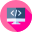 ☑️ **TODO: create the dataset and dataloaders** 

You should know how to do it. We did it int the previous lab.

**Create the class** to serve the dataset items.

**Create the dataloaders** for each split. **Use batch_size to 1 !**

In [ ]:
from torch.utils.data import Dataset
import numpy as np

class EnfrDataset(Dataset):
    # CODE ME !!

In [ ]:
from torch.utils.data import DataLoader
# CODE ME !!

# <font color="chillipepper">**The Model(s): Encoder Decoder**</font>

## <font color="chillipepper">CUDA, CPU, GPU, what is it?</font>

As tackled is the lab 3-4, the GPU is the graphical processing unit, in order words: your graphic card. For computational purposes we mostly use Nvidia cards, which implements a dedicated language named CUDA. Hence, CUDA is available with all Nvidia cards such as the (impossible to get and overpriced) RTX 3090, Tesla, etc.

To enable GPU, please verify or change your execution parameters in "execution -> modify the execution type" and select "GPU".

Let's check our GPU

In [ ]:
# let's check our GPU if any
! nvidia-smi

You can see this GPU is a Tesla K80 with CUDA Versio 11.2. It possesses ~11 Gb of RAM and is used at 0% (because we did not start any training).

Now let's check our CPU:

In [ ]:
# let's check our CPU
! lscpu

You can see our CPU (i.e. the processor), is an Intel Xeon with 2.30GHz cadency. This is ok, not the best, and it is necessary to prefer the GPU for computational speed. PyTorch let's you handle CPU and GPU as you wishes.

In [ ]:
# torch.cuda.is_available() returns a boolean to check if the GPU can be used or not
if torch.cuda.is_available():
  # if CUDA is available set 'cuda' as the device
  device = 'cuda'
  # and then print the name of the GPU
  print('DEVICE = ', colored(torch.cuda.get_device_name(0), "green" ) )
else:
  # else, set 'cpu' as device
  device = 'cpu'
  # just print than the CPU is used. Alternatively you can check your CPU with the following command (linux based) in the next cell:
  # ! lscpu
  print('DEVICE = ', colored('CPU', "blue"))

## <font color="chillipepper">Define the Encoder</font>

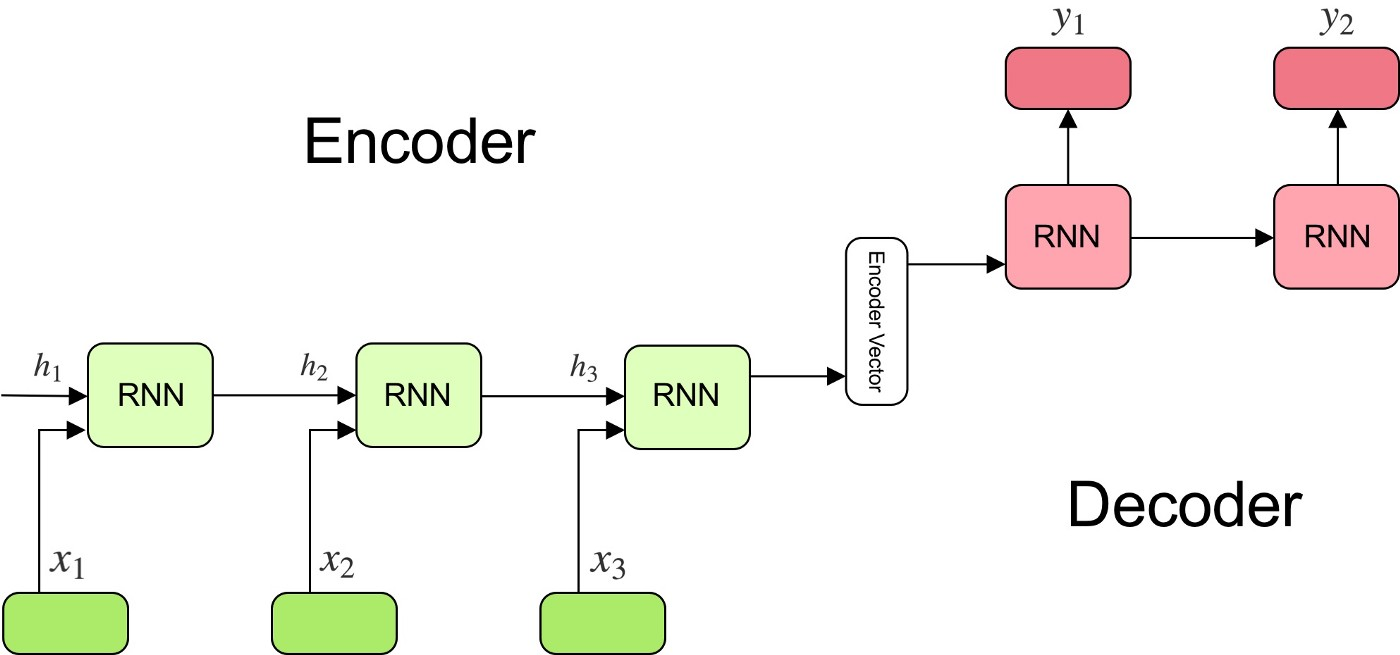

Source : https://towardsdatascience.com/understanding-encoder-decoder-sequence-to-sequence-model-679e04af4346

The encoder will encode the input, i.e. transform it into a vector of information as follows (source: https://ichi.pro/fr/traduction-automatique-neuronale-utilisant-un-modele-de-sequence-a-sequence-24508576939223):

<img src="https://miro.medium.com/max/724/1*R-Ul_DUk74cj79bPr5UalQ.gif" />

We use a recurrent layer for this. However, LSTM are complex and difficult, and long to train on such very small dataset. This is why we will use the Gated Recurrent Unit here. This model has [been made in 2014 for machine translation](https://paperswithcode.com/paper/learning-phrase-representations-using-rnn). It can be summed up as a simpler version of LSTM.


Links:
- https://pytorch.org/docs/stable/generated/torch.nn.GRU.html



Gated_Recurrent_Unit,_type_1.svg

#### 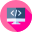 ☑️ **TODO: put the correct shape for the GRU layer**

Complete the following code (for both encoder and decoder) with the correct shape.

We pass an element at a time, but the GRU requires 3 dimensions. 
Change the dimension of the embedded tensor using the `.view()` method.

Tips:
- https://pytorch.org/docs/stable/generated/torch.Tensor.view.html

In [ ]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        # configurable hidden size
        self.hidden_size = hidden_size

        # we use an embedding layer
        self.embedding = nn.Embedding(input_size, hidden_size)
        # we define a GRU layer (Gated Recurrent Unit), a simpler version of recurrent layer and way simple than LSTM
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
      # move the input to the dedicated device (CPU or GPU)
      input = input.to(device)
      # apply the embedding layer
      embedded = self.embedding(input)
      
      
      # modify the output shape in order for it to work with a GRU (we use batches of one element)
      ############## CODE ME ###############
      output = # CODE ME, output should be of size (1, 1, hidden_size)


      # apply the GRU layer
      output, hidden = self.gru(output, hidden)
      # return both the output, and the hidden vector
      return output, hidden

    def initHidden(self):
        """ 
        method used to customize the hidden vector initialization.
        here the vector is initialized as 0 with the correct shape and created directly on the correct device
        """
        return torch.zeros(1, 1, self.hidden_size, device=device)

## <font color="chillipepper">Define the Decoder</font>

In [ ]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        # configurable hidden size
        self.hidden_size = hidden_size

        # we use an embedding layer
        self.embedding = nn.Embedding(output_size, hidden_size)
        # we define a GRU layer (Gated Recurrent Unit), a simpler version of recurrent layer and way simple than LSTM
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
      # move the input to the dedicated device (CPU or GPU)
        input = input.to(device)


        # apply the embedding layer and modify the output shape in order for it to work with a GRU (we use batches of one element)
        output = self.embedding(input)
        
        ################ CODE ME !! ####################
        output = # CODE ME !
        
        
        # apply a ReLU non linearization layer
        output = F.relu(output)
        # apply the GRU layer
        output, hidden = self.gru(output, hidden)
        # apply a softmax to get probabilities, on the first element of the output vector (batch is equal to one)
        output = self.softmax(self.out(output[0]))
        # return both the output probabilities and the hidden vector
        return output, hidden

    def initHidden(self):
        """ 
        method used to customize the hidden vector initialization.
        here the vector is initialized as 0 with the correct shape and created directly on the correct device
        """
        return torch.zeros(1, 1, self.hidden_size, device=device)

## <font color="chillipepper">Encoder-Decoder in the Training Loop</font>

In [ ]:
import random 
teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=maxlen):
    # put both encoder and decoder into trainning mode
    encoder.train()
    decoder.train()

    # use our custom initialization of hidden vector
    encoder_hidden = encoder.initHidden()

    # remove the gradient to prevent gradient accumulation
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    # adapt the tensor sizes
    input_tensor = input_tensor.view(input_tensor.size(1), input_tensor.size(0)) #input_tensor.view(1,1,-1)
    target_tensor = target_tensor.view(target_tensor.size(1), target_tensor.size(0)) #target_tensor.view(1,1,-1)

    # keep the lengths in memory
    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    # prepare an empty output with the correct size and the correct device
    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    # init the loss to 0
    loss = 0

    # pass each token of the input_tensor to the encoder, then populate the output
    for ei in range(input_length):
      if ei >= maxlen: break
      encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
      encoder_outputs[ei] = encoder_output[0, 0]

    # now we consider the decoder input, which starts only with the SOS token
    decoder_input = torch.tensor([[SOS_IDX]], device=device)

    # share the hidden vector from encoder to the decoder
    decoder_hidden = encoder_hidden

    # add a condition to teacher forcing
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden = decoder(
                decoder_input, decoder_hidden)
            # apply the NLL loss
            loss += criterion(decoder_output.to(device), target_tensor[di].to(device))
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
      # Without teacher forcing: use its own predictions as the next input
      for di in range(target_length):
          decoder_output, decoder_hidden = decoder(
              decoder_input, decoder_hidden)
          topv, topi = decoder_output.topk(1)
          decoder_input = topi.squeeze().detach()  # detach from history as input
          # compute the loss
          loss += criterion(decoder_output, target_tensor[di].to(device))
          # stop the iteration if the EOS token is predicted
          if decoder_input.item() == EOS_IDX:
              break
    
    # do the back propagation
    loss.backward()

    # notify each optimizers
    encoder_optimizer.step()
    decoder_optimizer.step()

    # return the average loss
    return loss.item() / target_length

In [ ]:
def sentence2tensor(entry, lang):
  """
  Function to transform an entry sentence into its corresponding indices as a tensor. 
  Needs to indicate the language to select the correct part of the vocabulary 
  """
  indices = [SOS_IDX] + [ VOC[lang]['stoi'][t] if t in VOC[lang]['stoi'] else 0 for t in tok.tokenize(entry.lower().strip()) ] + [EOS_IDX]
  print(indices)
  return torch.tensor(indices)

def evaluate(encoder, decoder, sentence, input_lang, target_lang, max_length=maxlen, input_tensor=None, target_tensor=None, criterion=None):
    """
    function to evaluate a translation of one sentence
    """
    # we evaluate, so we don't need gradients -> torch.no_grad()
    with torch.no_grad():
        
        if target_tensor is None: target_length = 0
        else: target_length = target_tensor.size(0)

        encoder_hidden = encoder.initHidden()
        
        # this condition adapts the function to either use a sentence as input, or a tensor
        if input_tensor is None:
          input_tensor = sentence2tensor(sentence, input_lang)
          # adapts the decoding length, useful for validation or test
          decoding_length = max_length
        else:
          decoding_length = target_length
        
        input_length = input_tensor.size(0)

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        # iterate through the input length 
        for ei in range(input_length):
            if ei >= maxlen: break
            encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_IDX]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        
        # init the loss (the loss is important is the cirterion is given - i.e. validation phase)
        loss = 0

        # iterate through decoding values, feeding the output for the next token until the condition or maximum lenght is reached
        for di in range(decoding_length):
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_IDX:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(VOC[target_lang]['itos'][topi.item()])

            decoder_input = topi.squeeze().detach()

            if target_tensor != None and criterion is not None:
              loss += criterion(decoder_output.to(device), target_tensor[di].unsqueeze(0).to(device))
              if decoder_input.item() == EOS_IDX:
                break

        return decoded_words, loss

In [ ]:
def inference(target, loader, encoder, decoder, criterion, langorder, limit=0):
  """
  fucntion to apply the inference logic over multiple translation and return a score
  used for validation
  """
  encoder.eval()
  decoder.eval()
  loss_it, glue_it = list(), list()
  preds, trues = list(), list()

  total = loader.__len__()
  if limit > 0: total = limit

  # iterate through the loader, can be a validation or test loader
  for it, batch in tqdm(enumerate(loader), desc="%s:" % (target), total=total):
    
    if limit > 0 and it >= limit: break

    input_tensor = batch[langorder[0]].squeeze()
    target_tensor = batch[langorder[1]].squeeze()

    input_lang = langorder[0]
    target_lang = langorder[1]
    # dummy sentence because this function is used for validation, not on-demand test
    mock_sentence = "dummy sentence not used"

    # compute entry and target sentences as "real text"
    entry = [VOC[input_lang]['itos'][t] for t in input_tensor.tolist()]
    entry = ' '.join( [e for e in entry if e not in ['<pad>', '<sos>', '<eos>', '<EOS>']] )
    true =  [VOC[target_lang]['itos'][t] for t in target_tensor.tolist()]
    true = ' '.join( [r for r in true if r not in ['<pad>', '<sos>', '<eos>', '<EOS>']] )
    trues.append([true])

    pred, loss = evaluate(encoder, decoder, mock_sentence, input_lang, target_lang, input_tensor=input_tensor, target_tensor=target_tensor, criterion=criterion)
    pred = ' '.join( [ h for h in pred if h not in ['<pad>', '<sos>', '<eos>', '<EOS>'] ] )
    preds.append(pred)
    if criterion is not None: 
      try:
        loss_it.append(loss.item())
      except: pass
    else: loss_it.append(loss)

  bleu = BLEU()
  bleu_score = bleu.corpus_score(preds, trues)

  loss_it_avg = sum(loss_it)/len(loss_it)

  print("%s : (%s %s) (%s %s)" % ( colored(target, 'blue'), colored('loss', 'cyan'), loss_it_avg, colored('blue', 'cyan'), bleu_score ))

  return trues, preds, loss_it_avg, loss_it, bleu_score 

# <font color="chillipepper">**Start Training 📉**</font>

In [ ]:
import torch.optim as optim

def run_epochs(encoder, decoder, max_epochs, learning_rate=0.01, langorder=['en','fr'], limit=0):    
    
    # define the optimizer for both encoder and decoder separately.
    # You can change it later on
    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    epoch_losses = []
    val_epoch_losses = []

    for ep in range(max_epochs):
      
      # TRAINING
      it_losses = []

      total = train_loader.__len__()
      # allow to limit the number of random samples per epoch
      if limit > 0: total = limit

      for iter, batch in tqdm(enumerate(train_loader), desc="Epoch %s:" % (ep), total=total):
          # trigger the limit if it is set
          if limit > 0 and iter >= limit: break

          input_tensor = batch[langorder[0]]
          target_tensor = batch[langorder[1]]

          loss = train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
          it_losses.append(loss)

      epoch_loss = sum(it_losses)/len(it_losses)
      epoch_losses.append(epoch_loss)
      print("Epoch %s : %s : (%s %s) " % (colored(str(ep), 'blue'), colored('Training', 'blue'), colored('loss', 'cyan'), epoch_loss  ))

      
      # VALIDATION
      trues, preds, val_loss_it_avg, val_loss_it, bleu_score = inference("validation", val_loader, encoder, decoder, criterion, langorder, limit=limit)
      val_epoch_losses.append(val_loss_it_avg)

      
    return epoch_losses, val_epoch_losses

In [ ]:
# the hidden size is up to you, higher value yields longer training time
hidden_size = 256
langorder = ['fr', 'en']
epochs = 3

# instanciate the encoder
encoder1 = EncoderRNN(VOC[langorder[0]]['nbwords'], hidden_size).to(device)
# instanciate the decoder
decoder1 = DecoderRNN(hidden_size, VOC[langorder[1]]['nbwords']).to(device)

# run the epochs
loss_list, val_loss_list = run_epochs(encoder1, decoder1, epochs, learning_rate=0.01, limit=200, langorder=langorder)

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_loss(loss_list):
  '''
  this function creates a plot. a simple curve showing the different values at each steps.
  Here we use it to plot the loss so we named it plot_loss, but the same function with different titles could be used to plot accuracies
  or other metrics for instance.
  
  Args:
    loss_list (list of floats): list of numerical values
  '''
  plt.plot(range(len(loss_list)), loss_list)
  plt.xlabel('epochs')
  plt.ylabel('NLL')
  plt.title('lr: {}, optim_alg:{}'.format(0.01, 'SGD'))
  plt.show()

In [ ]:
# train loss
plot_loss(loss_list)

In [ ]:
# val loss
plot_loss(val_loss_list)

What would be the pros and cons of using batches?
- padding would break the performances
- left or right padding and trim would generate noisy data (missing data) in the temporal representation

# <font color="chillipepper">**Evaluations 📊**</font>

## <font color="chillipepper">Evaluate on Test 📊</font>

We use the BLEU score to evaluate our translation.

Here is the original paper: https://aclanthology.org/P02-1040.pdf

In [ ]:
trues, preds, test_loss_it_avg, test_loss_it, bleu_score = inference("test", test_loader, encoder1, decoder1, None, langorder, limit=1000)
print(bleu_score)

## <font color="chillipepper">On-demand Subjective Evaluation 💻⌨️</font>

Let's try an arbitrary sentence

In [ ]:
evaluate(encoder1, decoder1, "Fumer te fera beaucoup de mal.", "fr", "en")

Let's create a random evaluation function

In [ ]:
def evaluateRandomly(encoder, decoder, input_lang, target_lang, n=10):
    refs, hyps = [], []
    criterion = nn.NLLLoss()
    
    for i in range(n):
        batch = next(iter(train_loader))

        input_tensor = batch['en'].squeeze()
        target_tensor = batch['fr'].squeeze()

        entry = [VOC[input_lang]['itos'][t] for t in input_tensor.tolist()]
        entry = ' '.join( [e for e in entry if e not in ['<pad>', '<sos>', '<eos>', '<EOS>']] )
        ref =  [VOC[target_lang]['itos'][t] for t in target_tensor.tolist()]
        ref = ' '.join( [r for r in ref if r not in ['<pad>', '<sos>', '<eos>', '<EOS>']] )
        refs.append([ref])

        print('>', entry )
        print('=', ref )

        hyp, _ = evaluate(encoder1, decoder1, "dummy", "en", "fr", input_tensor=input_tensor, target_tensor=target_tensor, criterion=criterion)
        print('<', ' '.join(hyp), '\n')
        hyp = ' '.join( [ h for h in hyp if h not in ['<pad>', '<sos>', '<eos>', '<EOS>'] ] )
        hyps.append(hyp)

    return refs, hyps

In [ ]:
refs, hyps = evaluateRandomly(encoder1, decoder1, "fr", "en")

Compute the BLEU score

In [ ]:
bleu = BLEU()
print(hyps)
result = bleu.corpus_score(hyps, refs)
print(result)

#### 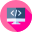 ☑️ **TODO: Create an interative translation**

Get the input text from the user, and translate it ot French on-demand.

Tips:
- use `input()` function from Python
- use the `evaluate()` function

In [ ]:
# ####### CODE ME

# <font color="chillipepper">**Conclusion**</font>

In this lab you gained the following:
- building your own vocabulary
- machine translation differencies in data representation and training loop
- encoder-decoder simple models with a bit of teacher forcing
- machine translation evaluation with BLUE

The model's performance is not satisfying if we only consider a small subset. However, training takes a long time. **Try to train it for a longer time and compare the results!**: just adjust the `limit`, `epochs` and `maxlen` variables.